In [2]:
import pandas as pd
import os
import numpy as np
from functools import reduce
import time
from datetime import datetime
to_datetime = lambda d: pd.to_datetime(d, format='%d/%m/%Y')

In [27]:
def chimp_finder(mean_size, var_med_thresh):
    
    dir = '../cotacoes/dados/b3/cotacoes_diarias/'

    # arquivo = 'QUAL3.sa.csv'

    ## Inicio
    inicio = time.perf_counter()
    micos = pd.DataFrame()
    x = y = 0

    ## Varrer os arquivos no diretório
    for arquivo in os.listdir(dir):

        ## Lê os arquivos
        cotacoes = pd.read_csv(dir + arquivo, parse_dates=['date'], date_parser=to_datetime).sort_values(by='date', ascending=True)

        ## Cálculos
        cotacoes['simbolo'] = arquivo[0:-7]
        cotacoes['vol_med'] = cotacoes['vol'].rolling(window=mean_size).mean()      ## Média Móvel do Volume
        cotacoes['var_vol'] = cotacoes['vol']/cotacoes['vol'].shift(1)        ## Variação do Volume no dia
        cotacoes['var_med'] = cotacoes['vol']/cotacoes['vol_med']             ## Variação do Volume em relação a Média Móvel
        cotacoes['saida'] = cotacoes['open'].shift(-1)                        ## Saída da Estratégia
        cotacoes['lucro'] = cotacoes['saida'] - cotacoes['close']             ## Lucro da Estrategia
        cotacoes['var_lucro'] = (cotacoes['lucro']/cotacoes['close']) * 100   ## Variação % do Lucro
        cotacoes['var_close'] = (cotacoes['saida'] / cotacoes['saida'].shift(1) - 1) * 100 ## Variação % do Fechamento

        ## Seleção
        selecao = (cotacoes['var_vol'] >= 0) & (cotacoes['var_med'] >= var_med_thresh) ## Variação diária ou relativa a média > 10

        if len(micos) == 0:
            micos = cotacoes[selecao].copy()
        else:
            micos = micos.append(cotacoes[selecao])

        ## Contadores
        x += 1
        y += len(cotacoes)

    micos.set_index(['simbolo','date'], inplace=True)
    
    micos = micos.dropna(axis=0, how='any') # removes NaN lines

    ## Fim
    fim = time.perf_counter()
    
    return micos

number of chimps: 18862
acumulated profit: -0.0


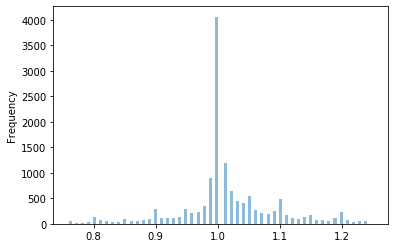

In [37]:
micos = chimp_finder(100, 5)
print('number of chimps: ' + str(len(micos)))
print('acumulated profit: ' + str(reduce(lambda x, y: x*y, micos['lucro'])))
micos = (micos[abs(micos['lucro'])<0.25]['lucro']+1)
micos.plot.hist(bins=100, alpha=0.5)
